STAT 453: Deep Learning (Spring 2020)    
Author: Sukyoung Cho (scho83@wisc.edu)
        Sihan Li (sli677@wisc.edu)
        Crystal Liu (mliu323@wisc.edu)


GitHub repository: https://github.com/SukyoungCho/Apple-Stock-Price-prediction-using-LSTM

---

# STAT 453 Final Project: Predicting Apple Stock Price using LSTM
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.layers import LSTM,Dense
from keras.models import Sequential

Using TensorFlow backend.


## Analyzing the data
The goal of this project is to predict the Stock Price (specifically 'Closing Price') of Apple. We are trying to predict stock prices of `20` periods (`num_periods`) of future `10` days (`future`) based on the `30` past days (`past`).

In [2]:
past = 40
future = 10
num_periods = 20

First, read the stock price dataset (`csv`) with Pandas, having the `Date` as index and analyze the data.

In [3]:
#read the dataset
df = pd.read_csv('apple.csv')
#date as index for time series analysis
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

#analyze the data (insights)
len(df)
df.head()
df.describe()

,Open,High,Low,Close,Volume
count,2585.000000,2585.000000,2585.000000,2585.000000,2.585000e+03
mean,115.095528,116.193296,114.010290,115.143981,2.918073e+07
std,62.590973,63.331304,62.020452,62.733800,1.861466e+07
min,27.510000,28.000000,27.180000,27.440000,1.643460e+05
25%,65.500000,66.090000,64.870000,65.470000,1.612881e+07
50%,100.600000,101.760000,100.110000,100.960000,2.455348e+07
75%,155.840000,157.080000,154.320000,155.840000,3.658921e+07
max,324.740000,327.850000,323.350000,327.200000,1.898463e+08


### Data Visualization

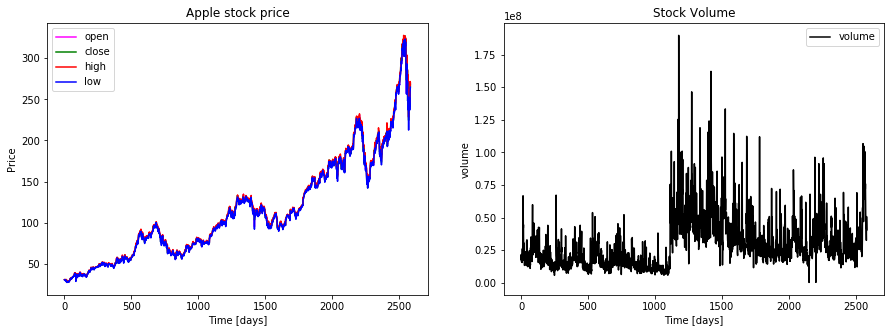

In [4]:
# Stock price graph with all attributes
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df['Open'].values, color='magenta', label='open')
plt.plot(df['Close'].values, color='green', label='close')
plt.plot(df['High'].values, color='red', label='high')
plt.plot(df['Low'].values, color='blue', label='low')
plt.title('Apple stock price')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
#plt.show()

# Trade Volume graph
plt.subplot(1,2,2);
plt.plot(df['Volume'].values, color='black', label='volume')
plt.title('Stock Volume')
plt.xlabel('Time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

After analyzing the data, we decided to take only closing price (`Close`) as stock price.

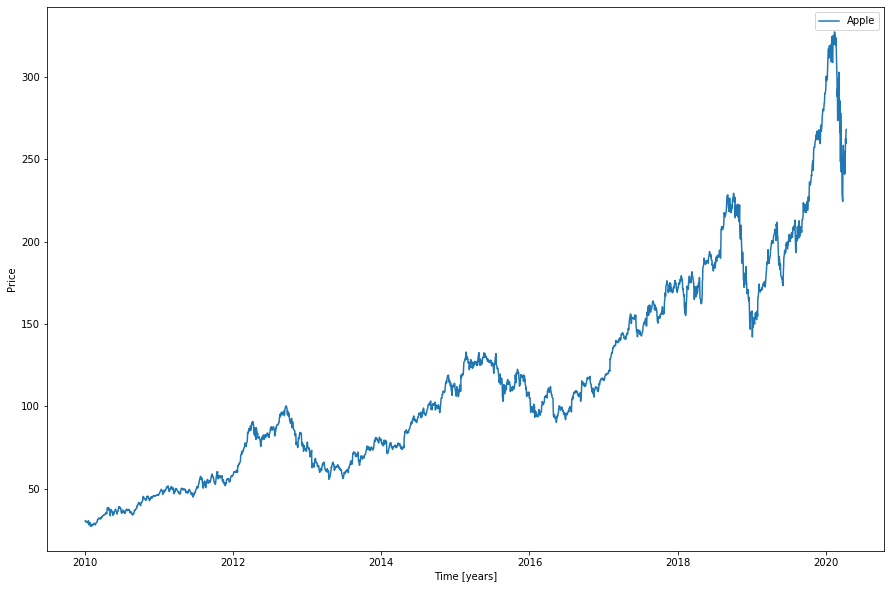

In [5]:
#keep 'Close' only
df = df['Close']

plt.figure(figsize = (15,10))
plt.plot(df, label='Apple')
plt.xlabel('Time [years]')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

### Data normalization
The data is not normalized and the range varies a lot. Normalizing the data is essential for the algorithm to converge, enabling to find local/ global minimum more efficiently. From the graphs above, we can tell the huge varaince in volume especially. MinMaxScaler from Sci-kit Learn is used here.

In [6]:
array = df.values.reshape(df.shape[0],1)
array[:5]

array([[30.57],
       [30.63],
       [30.14],
       [30.08],
       [30.28]])

In [7]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
array = scl.fit_transform(array)
array[:5]

array([[0.01044169],
       [0.01064185],
       [0.00900721],
       [0.00880705],
       [0.00947425]])

### Spliting the data into Train, Validate, and Test sets.

The Test sets are the last `k` (`num_periods`) periods to test the LSTM model. In each period, the model will predict the next `n` days based on the previous days. The remaning data will be used to train or validate the model.

In [8]:
#spliting into Train and Test sets

split_index = len(array) - num_periods*future

test_array = array[split_index-past:]
train_array = array[:split_index]

In [9]:
#Get the data and splits based on the numbers of 'future' and 'past'
def processData(data, past, future,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) - past - future +1, jump):
        X.append(data[i:(i+past)])
        Y.append(data[(i+past):(i+past+future)])
    return np.array(X),np.array(Y)

In [10]:
X_test,y_test = processData(test_array,past,future,future)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(train_array,past,future)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [11]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(1868, 40, 1)
(468, 40, 1)
(20, 40, 1)
(1868, 10)
(468, 10)
(20, 10)


## Training the LSTM model

In [12]:
# Hidden layers and the number of neurons for each layer
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 50

#Building the LSTM model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(past,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(future))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)

Train on 1868 samples, validate on 468 samples
Epoch 1/50
 - 26s - loss: 0.0018 - val_loss: 7.4852e-04
Epoch 2/50
 - 27s - loss: 5.7514e-04 - val_loss: 3.3934e-04
Epoch 3/50
 - 27s - loss: 4.7797e-04 - val_loss: 6.5441e-04
Epoch 4/50
 - 27s - loss: 4.1046e-04 - val_loss: 3.1544e-04
Epoch 5/50
 - 27s - loss: 3.9642e-04 - val_loss: 2.9064e-04
Epoch 6/50
 - 28s - loss: 3.4931e-04 - val_loss: 3.2066e-04
Epoch 7/50
 - 27s - loss: 3.3345e-04 - val_loss: 2.5888e-04
Epoch 8/50
 - 27s - loss: 3.2103e-04 - val_loss: 2.9189e-04
Epoch 9/50
 - 27s - loss: 3.2084e-04 - val_loss: 2.7753e-04
Epoch 10/50
 - 27s - loss: 2.9716e-04 - val_loss: 3.1181e-04
Epoch 11/50
 - 26s - loss: 3.1853e-04 - val_loss: 2.4154e-04
Epoch 12/50
 - 26s - loss: 2.9264e-04 - val_loss: 2.4445e-04
Epoch 13/50
 - 26s - loss: 2.8217e-04 - val_loss: 2.7630e-04
Epoch 14/50
 - 26s - loss: 2.9378e-04 - val_loss: 2.2751e-04
Epoch 15/50
 - 26s - loss: 2.8512e-04 - val_loss: 3.0429e-04
Epoch 16/50
 - 26s - loss: 2.9234e-04 - val_loss: 2

### Visualization of loss

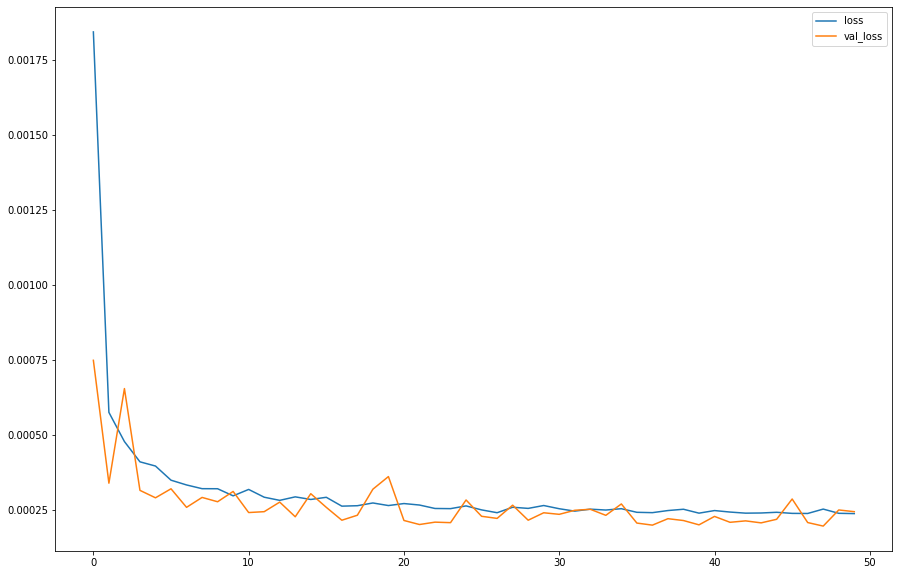

In [13]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

### Prediction Results on the Test Set

In [14]:
Xt = model.predict(X_test)

Drawing a plot with actual price in a `blue` line and predicted price in `red` line

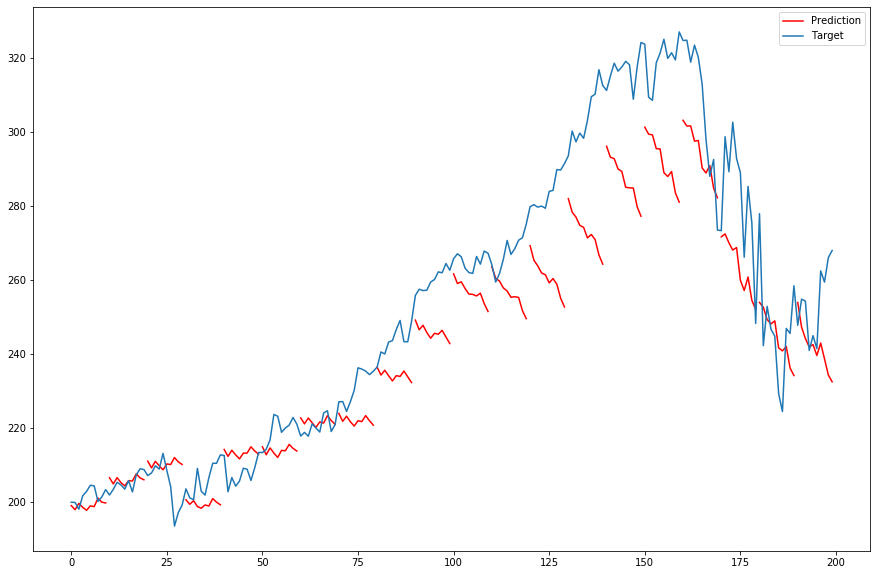

In [15]:
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*future for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction')
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

## Prediction over the whole timeline
In addition to periodic predictions, we would like to see if our model is able to make a precise and accurate prediction, following the overall trend.

In [16]:
#index for split
split = len(array) - num_periods*future

#The remaing part for future prediction
rest = split%future+1

test_array = array[split-past:]
train_array = array[rest:split]

In [17]:
# split into train and test sets
Xtrain,ytrain = processData(train_array,past,future,future)
Xtest,ytest = processData(test_array,past,future,future)

# train and test the model
Xtrain = model.predict(Xtrain)
Xtrain = Xtrain.ravel()

Xtest = model.predict(Xtest)
Xtest = Xtest.ravel()

y = np.concatenate((ytrain, ytest), axis=0)

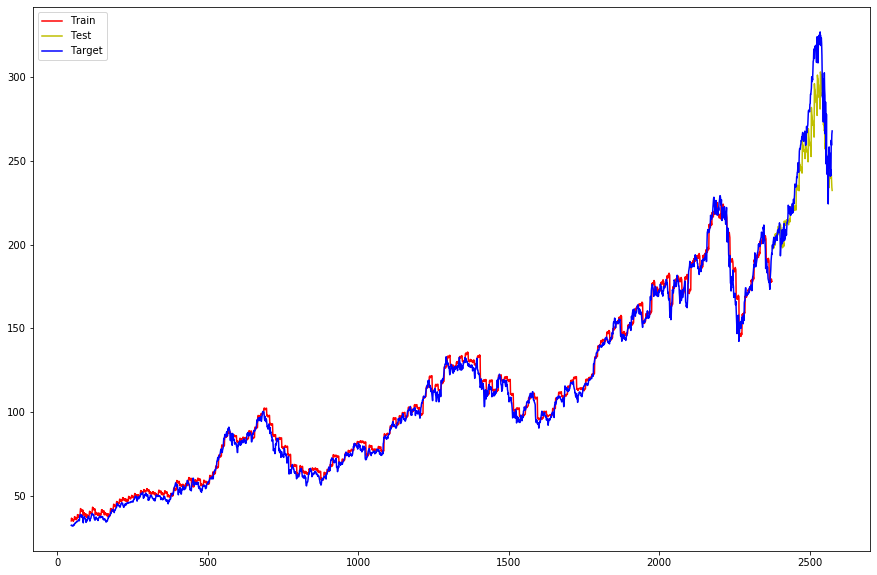

In [18]:
plt.figure(figsize = (15,10))

# Train & Validation Sets
plt.plot([x for x in range(past+rest, len(Xtrain)+past+rest)], scl.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train')
# Test Set
plt.plot([x for x in range(past +rest+ len(Xtrain), len(Xtrain)+len(Xtest)+past+rest)], scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test')

#Data used
plt.plot([x for x in range(past+rest, past+rest+len(Xtrain)+len(Xtest))], scl.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

plt.legend(loc='best')
plt.show()